In [20]:
!pip install s_dbw

You should consider upgrading via the '/Users/anna/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [21]:
import Wishart
from Wishart import Wishart
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score
import pickle
from sklearn.cluster import KMeans
from s_dbw import SD

In [17]:
#https://github.com/intelligent-environments-lab/ProfileClustering/blob/master/Clustering%20Analysis/Clustering%20Validation%20Metrics.ipynb
# метрики взяты с этого сайта 
def divide(data, labels):
    clusters = set(labels)
    clusters_data = []
    for cluster in clusters:
        clusters_data.append(data[labels == cluster, :])
    return clusters_data

def get_centroids(clusters):
    centroids = []
    for cluster_data in clusters:
        centroids.append(cluster_data.mean(axis=0))
    return centroids

def SST(data):
    c = get_centroids([data])
    return ((data - c) ** 2).sum()

def SSE(clusters, centroids):
    result = 0
    for cluster, centroid in zip(clusters, centroids):
        result += ((cluster - centroid) ** 2).sum()
    return result

# Clear the store before running each time
within_cluster_dist_sum_store = {}
def within_cluster_dist_sum(cluster, centroid, cluster_id):
    if cluster_id in within_cluster_dist_sum_store:
        return within_cluster_dist_sum_store[cluster_id]
    else:
        result = (((cluster - centroid) ** 2).sum(axis=1)**.5).sum()
        within_cluster_dist_sum_store[cluster_id] = result
    return result

def RMSSTD(data, clusters, centroids):
    df = data.shape[0] - len(clusters)
    attribute_num = data.shape[1]
    return (SSE(clusters, centroids) / (attribute_num * df)) ** .5

# equal to separation / (cohesion + separation)
def RS(data, clusters, centroids):
    sst = SST(data)
    sse = SSE(clusters, centroids)
    return (sst - sse) / sst

def DB_find_max_j(clusters, centroids, i):
    max_val = 0
    max_j = 0
    for j in range(len(clusters)):
        if j == i:
            continue
        cluster_i_stat = within_cluster_dist_sum(clusters[i], centroids[i], i) / clusters[i].shape[0]
        cluster_j_stat = within_cluster_dist_sum(clusters[j], centroids[j], j) / clusters[j].shape[0]
        val = (cluster_i_stat + cluster_j_stat) / (((centroids[i] - centroids[j]) ** 2).sum() ** .5)
        if val > max_val:
            max_val = val
            max_j = j
    return max_val

def DB(data, clusters, centroids):
    result = 0
    for i in range(len(clusters)):
        result += DB_find_max_j(clusters, centroids, i)
    return result / len(clusters)

def XB(data, clusters, centroids):
    sse = SSE(clusters, centroids)
    min_dist = ((centroids[0] - centroids[1]) ** 2).sum()
    for centroid_i, centroid_j in list(product(centroids, centroids)):
        if (centroid_i - centroid_j).sum() == 0:
            continue
        dist = ((centroid_i - centroid_j) ** 2).sum()
        if dist < min_dist:
            min_dist = dist
    return sse / (data.shape[0] * min_dist)

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    
    
    CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']
    
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    DIAMETER_METHODS = ['mean_cluster', 'farthest']
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters


def dunn(data, labels, diameter_method='farthest',
         cdist_method='nearest'):
    distances = euclidean_distances(data)
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))

    return min_distance / max_diameter

def mod_hubert_statistic(data, clusters, centroids):
    index = 0 
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            if i == j:
                continue
            
            d_c = np.linalg.norm(np.array(centroids[i]) - np.array(centroids[j]))
            for x in clusters[i]:
                for y in clusters[j]:
                    index += np.linalg.norm(np.array(x) - np.array(y)) * d_c
    return index * 2 /(len(data) * (len(data) - 1))

def i_index(data, clusters, centroids):
    c = data.mean(axis=0)
    sum_d_c = np.sum(np.linalg.norm(data - c, axis=1))
    m = 0
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            m = max(m, np.linalg.norm(centroids[i] - centroids[j]))
    s = 0
    for i in range(len(clusters)):
        s += np.sum(np.linalg.norm(clusters[i] - centroids[i], axis=1))
    return (sum_d_c * m / (len(clusters) * s))**len(data[0])

def Sep(labels, k, dk, dist):
    clusters = sorted(set(labels))
    max_sep = None
    for cluster in clusters:
        cluster_data = dist[labels == cluster]
        cluster_data = cluster_data[:, labels != cluster]
        cluster_dk = dk[labels == cluster]
        sep = len(cluster_data[cluster_data <= np.c_[cluster_dk]]) / (k * cluster_data.shape[0])
        if max_sep is None or max_sep < sep:
            max_sep = sep
    return max_sep

def Com(labels, dist):
    clusters = sorted(set(labels))
    com = 0
    max_com = 0
    for cluster in clusters:
        cluster_data = dist[labels == cluster]
        cluster_data = cluster_data[:, labels == cluster]
        n_i = cluster_data.shape[0]
#        print(n_i, cluster_data.sum())
        if n_i > 1:
            cur_sum = 2 * cluster_data.sum() / (n_i * (n_i - 1))
            com += cur_sum
            if max_com < cur_sum:
                max_com = cur_sum
    return com, max_com

def CVNN(labels, k, dk, dist):
    com, max_com = Com(labels, dist)
    return Sep(labels, k, dk, dist) + com / max_com 

def get_validation_scores(data, labels, k, dk, dist):
    within_cluster_dist_sum_store.clear()
    
    clusters = divide(data, labels)
    centroids = get_centroids(clusters)
    
    scores = {}
#     scores['1 RMSSTD'] = RMSSTD(data, clusters, centroids)
    scores['RS'] = RS(data, clusters, centroids)
#     scores['3 H'] = mod_hubert_statistic(data, clusters, centroids)
#     scores['CH'] = calinski_harabasz_score(data, labels)
#     scores['5 I'] = i_index(data, clusters, centroids)
#     scores['6 D'] = dunn(data, labels)
#     scores['7 S'] = silhouette_score(data, labels)
#     scores['8 DB'] = DB(data, clusters, centroids)
    scores['XB'] = XB(data, clusters, centroids)
    scores['SD'] = SD(data, labels)
#     scores['11 S_Dbw'] = S_Dbw(data, labels)
#     scores['12 CVNN'] = CVNN(labels, k, dk, dist)
    return scores

In [3]:
# Скачиваем словарь слов - эмбедингов BERT
dictionary_BERT = pickle.load(open("dict_emb_word_BERTA.pkl", 'rb'))

In [4]:
# Достаем эмбединги
dict_BERT = dictionary_BERT.values()
dict_BERT = np.array(list(dict_BERT))

<ipython-input-4-56fd4123c8e4>:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  dict_BERT = np.array(list(dict_BERT))
<ipython-input-4-56fd4123c8e4>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dict_BERT = np.array(list(dict_BERT))


In [5]:
dict_BERT.shape

(69816,)

In [6]:
for i in range(len(dict_BERT)):
    dict_BERT[i] = dict_BERT[i].numpy()

In [7]:
dict_BERT = np.vstack(dict_BERT)

In [8]:
# Возьмем подвыборку для обучения
small_dict_BERT1 = np.array(pd.DataFrame(dict_BERT).loc[:15000])
small_dict_BERT2 = np.array(pd.DataFrame(dict_BERT).loc[20000:40000])
small_dict_BERT3 = np.array(pd.DataFrame(dict_BERT).loc[40000:])

In [9]:
words_BERT = dictionary_BERT.keys()
words_BERT = np.array(list(words_BERT))
small_words_BERT1 = np.array(pd.DataFrame(words_BERT).loc[:15000])
small_words_BERT2 = np.array(pd.DataFrame(words_BERT).loc[20000:40000])
small_words_BERT3 = np.array(pd.DataFrame(words_BERT).loc[40000:])

In [10]:
# Запустим алгоритм кластеризации Wishart на этой подвыборке
datasets_clustering = []
datasets_names = []
num_clusters = 2
k = 2
while num_clusters >= 2:
    WC = Wishart(k, 0.001)
    res = WC.fit(small_dict_BERT1)
    num_clusters = np.max(res)
    print(num_clusters)
    datasets_clustering.append((small_dict_BERT1, WC))
    datasets_names += ['k = ' + str(k)]
    k += 1

Start clustering
522
Start clustering
187
Start clustering
77
Start clustering
32
Start clustering
18
Start clustering
9
Start clustering
5
Start clustering
3


In [11]:
datasets_names

['k = 2', 'k = 3', 'k = 4', 'k = 5', 'k = 6', 'k = 7', 'k = 8', 'k = 9']

In [12]:
num_clusters = 2
k = 10
while num_clusters >= 2:
    WC = Wishart(k, 0.001)
    res = WC.fit(small_dict_BERT1)
    num_clusters = np.max(res)
    print(num_clusters)
    datasets_clustering.append((small_dict_BERT1, WC))
    datasets_names += ['k = ' + str(k)]
    k += 1

Start clustering
3
Start clustering
1


In [13]:
datasets_names

['k = 2',
 'k = 3',
 'k = 4',
 'k = 5',
 'k = 6',
 'k = 7',
 'k = 8',
 'k = 9',
 'k = 10',
 'k = 11']

In [22]:
from itertools import combinations, product
scores_list = []
dict_list = [] # список словарей 
for (data, WC), data_name in zip(datasets_clustering, datasets_names):
#     print(data_name)
    if(len(set(WC.object_labels)) == 1):
        print('Set with one cluster')
        continue
#     print(len(set(WC.object_labels)))
    scores = get_validation_scores(data, WC.object_labels, k=10, dk=WC.dk_, dist=WC.dist_)
    scores_list += [scores]
#     for key in scores: 
#         print('\t' + key + ': %.4f' % scores[key])
    dict_ = {}
    for i in set(WC.object_labels):
        dict_[i] =  small_words_BERT1[WC.object_labels==i]
    dict_list += [dict_]

Set with one cluster


In [23]:
from collections import defaultdict
metrics_k_grid = defaultdict(list)
k_grid = np.arange(2, 12, 1)
for i in range(len(scores_list)):
    scores = scores_list[i]
    for key in scores:
        metrics_k_grid[key].append(scores[key])

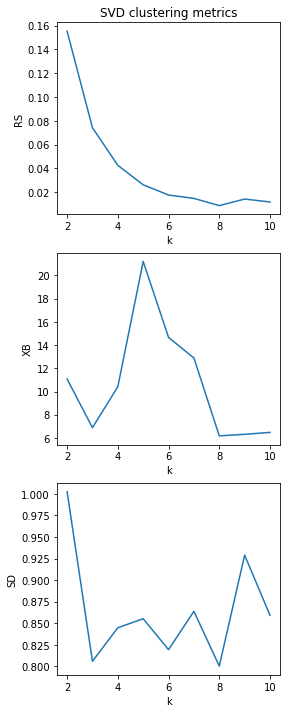

In [33]:
fig, axs = plt.subplots(3, figsize=(4,12))
for i in range(3):
    if i == 0: axs[i].set_title('SVD clustering metrics')
    metricname = list(metrics_k_grid.keys())[i]
    y = metrics_k_grid[metricname]
    axs[i].set_xlabel('k')
    axs[i].set_ylabel(metricname)
    axs[i].plot(k_grid[:len(y)], y)

In [25]:
dict_list[6]

{0: array([['от'],
        ['отказать'],
        ['в'],
        ...,
        ['неэлектрический'],
        ['недрагоценный'],
        ['резать']], dtype=object),
 1: array([['несоразмерность'],
        ['несоразмерный'],
        ['несоразмерности'],
        ['несоразмерного'],
        ['несоразмерно'],
        ['несоразмерен'],
        ['несоразмерны'],
        ['несоразмерностью'],
        ['несоразмерить'],
        ['несоразмерна'],
        ['мелкоразмерный'],
        ['несоразмерной']], dtype=object),
 2: array([['закрепление'],
        ['закрепить'],
        ['скрепить'],
        ['закреплять'],
        ['закрепляться'],
        ['скрепленый'],
        ['скреплять'],
        ['прикрепление'],
        ['прикрепить'],
        ['скрепленный'],
        ['подкрепление'],
        ['прикреплять'],
        ['подкрепить'],
        ['скреплен'],
        ['скрепленному'],
        ['скрепленные'],
        ['крепь'],
        ['скрепляться']], dtype=object),
 3: array([['перечисление'],
        [